In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
sns.set_style("whitegrid")

In [3]:
#Read in cleaned data
#df_train = pd.read_csv('data/cleaned_train_2005.csv')
df_train = pd.read_csv('data/cleaned_train_full_2005.csv')
df_train.head()

,Title,Creator,UsageClass,MaterialType,Genre,CleanedPublisher,CheckoutMonth,CheckoutYear,PreviousYearCheckoutsSum,PreviousYearCheckoutsMean,PreviousYearPublished,PreviousYearPublishedMean,FirstYearCheckouts
0,"American seafood : heritage, culture & cookery...","Seaver, Barton",Physical,BOOK,other,other publisher,1,2018,113,2.670833,1,62.046138,9
1,The runaway pea / Kjartan Poskitt & Alex Willm...,"Poskitt, Kjartan",Physical,BOOK,juvenile,simon & schuster,2,2022,36,1.270833,2,0.000000,167
2,What the cat dragged in / Miranda James.,"James, Miranda",Physical,BOOK,mystery,other publisher,9,2021,487,2.027593,1,0.000000,31
3,R.F.K. : a photographer's journal / Harry Benson.,"Benson, Harry",Physical,BOOK,history,other publisher,11,2008,0,0.000000,1,63.876983,12
4,Ice Drift,Theodore Taylor,Digital,EBOOK,juvenile,harpercollins,11,2013,36,1.322222,2,0.000000,4


## Baseline Model: 

For our baseline model, we predict the number of first year checkouts for a library item as the average of all the first year checkout data. 

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

In [5]:
## Make KFold object to be used on training dataset
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 216)

In [ ]:
rmses = np.zeros(5)

for i, (train_index, test_index) in enumerate(kfold.split(df_train, df_train['FirstYearCheckouts'])):
    ## get the kfold training and holdout data
    X_tt = df_train.iloc[train_index]
    X_ho = df_train.iloc[test_index]

    #Get average of the first year checkouts for our train set 
    baseline_pred = np.ones(len(X_ho)) * X_tt['FirstYearCheckouts'].mean() 

    ## Record the rmses
    rmses[i] = root_mean_squared_error(X_ho['FirstYearCheckouts'], baseline_pred)

In [12]:
print(rmses)
print(rmses.mean())

[114.72254652 121.97266529 109.23361391 118.73402191 115.23831321]
115.98023216785975


In [84]:
print('The average number of first year checkouts for the whole training dataset is', df_train['FirstYearCheckouts'].mean())
print('The median number of first year checkouts in our dataset is', np.median(df_train['FirstYearCheckouts']))
print('The minimum and maximum first year checkouts in our dataset are', df_train['FirstYearCheckouts'].min(), \
      'and', df_train['FirstYearCheckouts'].max(), 'respectively')

The average number of first year checkouts for the whole training dataset is 44.87509717142807
The median number of first year checkouts in our dataset is 21.0
The minimum and maximum first year checkouts in our dataset are 1 and 9633 respectively


Our median and average are pretty low compared with the maximum we see; our distribution seems to have a long tail, so we will likely have higher RSMEs. 

In [13]:
df_train.columns

Index(['Title', 'Creator', 'UsageClass', 'MaterialType', 'Genre',
       'CleanedPublisher', 'CheckoutMonth', 'CheckoutYear',
       'PreviousYearCheckoutsSum', 'PreviousYearCheckoutsMean',
       'PreviousYearPublished', 'PreviousYearPublishedMean',
       'FirstYearCheckouts'],
      dtype='object')

## First Modeling Attempt: Linear Regression

For our first model, we will consider linear regression. We will train on all features outside of Title and Creator, and we one-hot encode the categorical variables UsageClass, MaterialType, Genre, CleanedPublisher. Since UsageClass is binary, we will replace this column with a 1 if the item is Physical and 0 if the item is Digital. 

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
#Get list of cateories for columns of one-hot encoding
genre_list = df_train['Genre'].unique().tolist()
material_list = df_train['MaterialType'].unique().tolist()
publisher_list = df_train['CleanedPublisher'].unique().tolist()

# One-hot encoding of 'Genre' variable
df_train[genre_list] = pd.get_dummies(df_train['Genre'])

# One-hot encoding of 'MaterialType' variables
df_train[material_list] = pd.get_dummies(df_train['MaterialType'])

# One-hot encoding of 'CleanedPublisher' variable
df_train[publisher_list] = pd.get_dummies(df_train['CleanedPublisher'])

#One hot encode UsageClass into single column with 1 indicating 'Physical' and 0 indicating 'Digital'
df_train['UsageClass'] = pd.get_dummies(df_train['UsageClass'])['Physical']
#df_train = df_train.drop(columns = ['Genre', 'MaterialType'])
df_train = df_train.drop(columns = ['Genre', 'MaterialType', 'CleanedPublisher'])

In [16]:
df_train.columns

Index(['Title', 'Creator', 'UsageClass', 'CheckoutMonth', 'CheckoutYear',
       'PreviousYearCheckoutsSum', 'PreviousYearCheckoutsMean',
       'PreviousYearPublished', 'PreviousYearPublishedMean',
       'FirstYearCheckouts', 'other', 'juvenile', 'mystery', 'history',
       'nonfiction', 'fiction', 'romance', 'fantasy/sci-fi', 'biography',
       'young adult', 'horror/thriller', 'BOOK', 'EBOOK', 'AUDIOBOOK',
       'SOUNDDISC', 'OTHER', 'VIDEODISC', 'other publisher',
       'simon & schuster', 'harpercollins', 'penguin random house', 'hachette',
       'blackstone', 'harlequin', 'macmillan', 'scholastic',
       'lightning source', 'recorded books', 'brilliance'],
      dtype='object')

In [27]:
# Features we want to train our linear regression on
features =['UsageClass', 'CheckoutMonth', 'CheckoutYear',
       'PreviousYearCheckoutsSum', 'PreviousYearCheckoutsMean',
       'PreviousYearPublished', 'PreviousYearPublishedMean'
       , 'other', 'juvenile', 'mystery', 'history',
       'nonfiction', 'fiction', 'romance', 'fantasy/sci-fi', 'biography',
       'young adult', 'horror/thriller', 'BOOK', 'EBOOK', 'AUDIOBOOK',
       'SOUNDDISC', 'OTHER', 'VIDEODISC', 'other publisher',
       'simon & schuster', 'harpercollins', 'penguin random house', 'hachette',
       'blackstone', 'harlequin', 'macmillan', 'scholastic',
       'lightning source', 'recorded books', 'brilliance']

In [28]:
# Kfold split
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 216)

In [121]:
# Array to store rmse
rmse = np.zeros(5)

# Initialize LinearRegression Model
lr = LinearRegression()

for i, (train_index, test_index) in enumerate(kfold.split(df_train, df_train['FirstYearCheckouts'])):

    ## get the kfold training and holdout data
    X_tt = df_train.iloc[train_index]
    X_ho = df_train.iloc[test_index]

    ## Fit model
    lr.fit(X_tt[features], X_tt['FirstYearCheckouts'])

    ## Generate predictions on the holdout set
    lr_preds = lr.predict(X_ho[features])

    ## Record the rmses
    rmses[i] = root_mean_squared_error(X_ho['FirstYearCheckouts'], lr_preds)

In [122]:
print(rmses)
print(rmses.mean())

[109.98766426 117.18175179 104.24685806 114.22175667 109.89098079]
111.10580231523207


## Adding Regularization: 

We add lasso regularization to our model to see what features are most important. We first run the regularizaiton with alpha = 0.1. 

In [32]:
from sklearn.linear_model import Lasso

In [35]:
# Kfold split
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 216)

# Array to store rmse
rmse = np.zeros(5)

#Initialize Lasso regression model
lasso = Lasso(alpha=0.1)  

for i, (train_index, test_index) in enumerate(kfold.split(df_train, df_train['FirstYearCheckouts'])):

    ## get the kfold training and holdout data
    X_tt = df_train.iloc[train_index]
    X_ho = df_train.iloc[test_index]

    ## Fit model
    lasso.fit(X_tt[features], X_tt['FirstYearCheckouts'])


    ## Generate predictions on the holdout set
    lasso_preds = lasso.predict(X_ho[features])

    ## Record the rmses
    rmses[i] = root_mean_squared_error(X_ho['FirstYearCheckouts'], lasso_preds)

In [36]:
print(rmses)
print(rmses.mean())

[110.01183039 117.20027996 104.26801716 114.2452093  109.94932836]
111.13493303349594


We see that this behaves very similarly to linear regression without regularization. We now search through different alpha values to see which values gives the best model and what features are most important. 

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
n =len(features)

lasso_coefs = np.empty((len(alpha),n))
rmses = np.empty(len(alpha))

## for each alpha value
for i in range(len(alpha)):
    print(alpha[i])
    print()
    
    ## set up the lasso pipeline
    lasso_pipe = Pipeline([('scale',StandardScaler()),
                              ('lasso', Lasso(alpha=alpha[i]))
                          ])
    
    ## fit the lasso
    lasso_pipe.fit(df_train[features], df_train['FirstYearCheckouts'])

    ## predict 
    pred = lasso_pipe.predict(df_train[features])
    rmses[i] = root_mean_squared_error(pred, df_train['FirstYearCheckouts'])


    # record the coefficients
    lasso_coefs[i,:] = lasso_pipe['lasso'].coef_

1e-05



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e+08, tolerance: 6.099e+05
  model = cd_fast.enet_coordinate_descent(


0.0001



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e+08, tolerance: 6.099e+05
  model = cd_fast.enet_coordinate_descent(


0.001



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e+08, tolerance: 6.099e+05
  model = cd_fast.enet_coordinate_descent(


0.01

0.1

1

10

100

1000



In [39]:
print("Lasso Coefficients")
pd.set_option('display.max_columns', None)
pd.DataFrame(np.round(lasso_coefs,8),
            columns = features,
            index = ["alpha=" + str(a) for a in alpha])

Lasso Coefficients


,UsageClass,CheckoutMonth,CheckoutYear,PreviousYearCheckoutsSum,PreviousYearCheckoutsMean,PreviousYearPublished,PreviousYearPublishedMean,other,juvenile,mystery,history,nonfiction,fiction,romance,fantasy/sci-fi,biography,young adult,horror/thriller,BOOK,EBOOK,AUDIOBOOK,SOUNDDISC,OTHER,VIDEODISC,other publisher,simon & schuster,harpercollins,penguin random house,hachette,blackstone,harlequin,macmillan,scholastic,lightning source,recorded books,brilliance
alpha=1e-05,1.664975,-0.964015,2.154109,10.139801,25.859853,-5.236976,-0.107529,1.812815,1.265832,3.098828,-0.885583,3.441402,-4.046213,1.388172,1.467246,-0.232567,1.666957,-2.078180,1.876726,9.303623,-4.319153,-1.559242,3.162130,0.666570,-2.300159,-3.481724,-0.521887,-0.105125,1.384022,-0.367599,0.848916,-3.964979,2.592150,-1.943754,-0.736035,2.041423
alpha=0.0001,1.664058,-0.963929,2.154056,10.139687,25.859816,-5.236870,-0.107438,1.782882,1.237379,3.058264,-0.912019,3.417605,-4.093303,1.360306,1.433842,-0.279802,1.641160,-2.099282,1.829955,9.231508,-4.386252,-1.577137,3.123854,0.662750,-2.285572,-3.472933,-0.506179,-0.096145,1.411146,-0.356666,0.867538,-3.914986,2.627753,-1.928767,-0.723138,2.060568
alpha=0.001,1.654891,-0.963070,2.153522,10.138550,25.859449,-5.235815,-0.106528,1.483553,0.952853,2.652626,-1.176379,3.179631,-4.564208,1.081643,1.099807,-0.752154,1.383193,-2.310301,1.362250,8.510351,-5.057241,-1.756090,2.741104,0.624550,-2.139704,-3.385022,-0.349091,-0.006343,1.682389,-0.247339,1.053758,-3.415061,2.983781,-1.778897,-0.594171,2.252015
alpha=0.01,1.993023,-0.955239,2.141577,10.127746,25.853330,-5.222673,-0.097726,0.482386,0.000000,1.297713,-2.050391,2.383210,-6.125209,0.147401,-0.000681,-2.315385,0.520149,-3.007046,-0.000000,6.015137,-7.012715,-2.315806,1.413071,0.486074,-1.806879,-3.180415,-0.000000,0.182016,2.283397,-0.000000,1.463387,-2.285995,3.769654,-1.436665,-0.298573,2.672745
alpha=0.1,4.257006,-0.875235,2.038845,10.016275,25.793761,-5.100807,-0.008933,0.447162,0.000000,1.265386,-1.928238,2.334171,-5.977353,0.075079,-0.000000,-2.119430,0.444656,-2.917202,-0.000000,3.465494,-6.910069,-2.518260,0.000000,0.263009,-1.727428,-3.087556,-0.000000,0.078069,2.159719,-0.000000,1.331534,-2.257082,3.585012,-1.350459,-0.233581,2.544852
alpha=1,2.692603,-0.030059,1.496581,8.966051,25.281457,-4.032972,-0.000000,0.342630,0.000000,1.208996,-0.483923,1.992429,-4.029570,0.000000,-0.000000,-0.000000,0.000000,-1.810563,0.000000,3.639780,-5.010462,-1.721461,0.000000,0.000000,-0.628492,-2.073609,-0.000000,0.000000,1.123811,-0.000000,0.150641,-1.865294,2.097519,-0.233642,-0.000000,1.376000
alpha=10,0.000000,-0.000000,0.000000,0.623988,18.233488,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000
alpha=100,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000
alpha=1000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000


PreviousYearCheckoutsMean is the feature with the coefficient of highest magnitude, with PreviousYearCheckoutSum and PreviousYearPublished also of larger magnitude. It is interesting to note that PreviousYearPublished has negative coefficients so that authors with books written in the last year have fewer checkouts.   UsageClass and CheckoutYear have coefficients of medium magntiude. In the Genre category, most of the coefficients are smaller, though those of nonfiction and fiction are of medium magnitude. Of the MaterialType categories, EBOOK and AUDIOBOOK are the most important with a positive coefficient for EBOOK but a negative one for AUDIOBOOKS. There are a few publishers with coefficients that are of slightly larger magnitude compared with the others, though most of the coefficients still stay on the smaller side.  We note that for large alpha values, none of the features are good indicators of FirstYearCheckout as all of the features zero out. 

In [40]:
print('RMSE by alpha: ')
for i in range(len(alpha)):
    print('Alpha', alpha[i], ':', rmses[i])

RMSE by alpha: 
Alpha 1e-05 : 111.17017748421029
Alpha 0.0001 : 111.1701774859389
Alpha 0.001 : 111.17017765880108
Alpha 0.01 : 111.17020068991974
Alpha 0.1 : 111.1721580317754
Alpha 1 : 111.29169576805603
Alpha 10 : 112.92470439838675
Alpha 100 : 116.05858206189905
Alpha 1000 : 116.05858206189905


We see that all of the alpha values give similar RMSEs compared with normal linear regression. 

## Additional Models: 

We now try a Random Forest, which should allow for non-linearity and will hopefully perform better as we do not expect our data to behave linearly based on earlier data exploration. 

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True, random_state=216)

# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(df_tt[features], df_tt['FirstYearCheckouts'])

# Make predictions on the test set
y_pred = model.predict(df_ho[features])

# Evaluate the model
rmse = root_mean_squared_error(df_ho['FirstYearCheckouts'], y_pred)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 103.95280888503329


This improves are error by about 10 checkouts, which is not a huge improvement, but still noticable. 

We now use KNN Regressor to model our problem and compare it with the RandomForest. 

In [42]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True, random_state=216)

neigh = Pipeline([ ( 'scale', StandardScaler()), ('knn', KNeighborsRegressor())])

neigh.fit(df_tt[features], df_tt['FirstYearCheckouts'])

# Make predictions on the test set
y_pred = neigh.predict(df_ho[features])

# Evaluate the model
rmse = root_mean_squared_error(df_ho['FirstYearCheckouts'], y_pred)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 109.43480298078369


This is still a slight improvement over the baseline model, but does worse than the RandomForest model. We now do a comparison of the RMSE from different numbers of neighbors to see what performs best; we only run this on a smaller subset of features for computational convenience. 

5
10
15
20
25
30
35
40
45
50


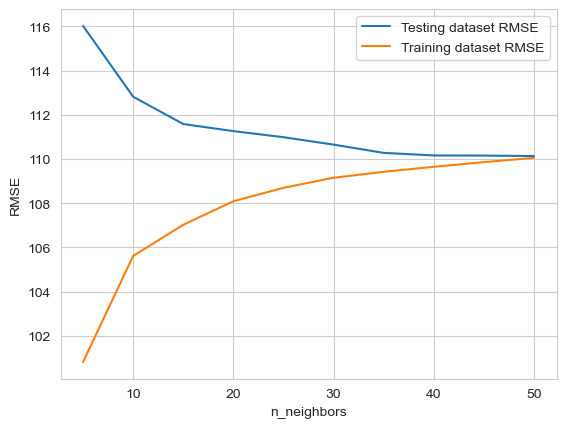

In [123]:
feature_prev = ['PreviousYearCheckoutsSum', 'PreviousYearCheckoutsMean']

neighbors = np.arange(5, 55, 5) 
train_rmse = np.empty(len(neighbors)) 
test_rmse = np.empty(len(neighbors)) 
  
# Loop over K values 
for i, k in enumerate(neighbors): 
    print(k)
    
    knn = Pipeline([ ( 'scale', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=k))])
    #knn.fit(df_tt[new_features], df_tt['FirstYearCheckouts']) 
    knn.fit(df_tt[feature_prev], df_tt['FirstYearCheckouts']) 
      
    # Compute training and test data accuracy 
    train_rmse[i] = root_mean_squared_error(knn.predict(df_tt[feature_prev]), df_tt['FirstYearCheckouts']) 
    test_rmse[i] = root_mean_squared_error(knn.predict(df_ho[feature_prev]), df_ho['FirstYearCheckouts']) 
  
  
# Generate plot 
plt.plot(neighbors, test_rmse, label = 'Testing dataset RMSE') 
plt.plot(neighbors, train_rmse, label = 'Training dataset RMSE') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('RMSE') 
plt.show() 

We also try XGBoost Regressor as another possible model. 

In [50]:
#!pip install xgboost
from xgboost import XGBRegressor

In [ ]:
# Split data into training and hold out set
df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True, random_state=216)

# Initialize model
xgb = XGBRegressor()

# Fit model
xgb.fit(df_tt[features], df_tt['FirstYearCheckouts'])

# Make predictions
pred = xgb.predict(df_ho[features])

rmse = root_mean_squared_error(pred, df_ho['FirstYearCheckouts'])

print('RMSE for XGBoost Regressor:', rmse)



101.82688008798233


We see that, by a small magnitude, XGBoost Regressor seems to perform the best of the models we have considered. 

We also try a small NN to see if it can capture any additional structure. 

In [52]:
from sklearn.neural_network import MLPRegressor

In [54]:
nn = MLPRegressor(
    activation='relu',
    hidden_layer_sizes=(100,),
    alpha=0.001,
    random_state=20,
    early_stopping=False
)

nn.fit(df_tt[features], df_tt['FirstYearCheckouts'])

pred = nn.predict(df_ho[features])

rmse = root_mean_squared_error(pred, df_ho['FirstYearCheckouts'])

print('RMSE for NN with 1 hidden layers each with 100 neurons:', rmse)


RMSE for NN with 1 hidden layers each with 100 neurons: 106.00505114384612


We note that this does not improve our estimate compared with RandomForest and XgBoost Regressor. 

### Predicting log(FirstYearCheckouts):

We could also look at predicting the order of magnitude of the first year checkouts, and consider instead predicting on the log of the FirstYearCheckouts with all the same models as above besides KNN as this did not provide much improvement. 

In [109]:
df_train['logFYC'] = np.log10(df_train['FirstYearCheckouts'])

#### Baseline:

In [110]:
## Make KFold object to be used on training dataset
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 216)


rmses = np.zeros(5)

for i, (train_index, test_index) in enumerate(kfold.split(df_train, df_train['logFYC'])):
    ## get the kfold training and holdout data
    X_tt = df_train.iloc[train_index]
    X_ho = df_train.iloc[test_index]

    #Get average of the first year checkouts for our train set 
    baseline_pred = np.ones(len(X_ho)) * X_tt['logFYC'].mean() 

    ## Record the rmses
    rmses[i] = root_mean_squared_error(X_ho['logFYC'], baseline_pred)

In [111]:
print(rmses)
print(rmses.mean())

[0.54403594 0.54392708 0.54377702 0.5427933  0.54642483]
0.5441916335734021


In [112]:
10**0.54

3.4673685045253166

As the RMSE is in log-space it behaves like a multipicative factor.  Thus, the model's predictions are, on average, about 3.47 times away from the actual values in the original space, providing a measure of multiplicative error rather than absolute error.

In [113]:
print('The average number of log first year checkouts for the whole dataset is', df_train['logFYC'].mean())
print('The minimum and maximum log first year checkouts in our dataset are', df_train['logFYC'].min(), \
      'and', df_train['logFYC'].max(), 'respectively')

The average number of log first year checkouts for the whole dataset is 1.2983440300851525
The minimum and maximum log first year checkouts in our dataset are 0.0 and 3.983761560286165 respectively


#### Linear Model: 

In [114]:
# Array to store rmse
rmse = np.zeros(5)

# Initialize LinearRegression Model
lr = LinearRegression()

for i, (train_index, test_index) in enumerate(kfold.split(df_train, df_train['logFYC'])):

    ## get the kfold training and holdout data
    X_tt = df_train.iloc[train_index]
    X_ho = df_train.iloc[test_index]

    ## Fit model
    lr.fit(X_tt[features], X_tt['logFYC'])

    ## Generate predictions on the holdout set
    lr_preds = lr.predict(X_ho[features])

    ## Record the rmses
    rmses[i] = root_mean_squared_error(X_ho['logFYC'], lr_preds)

In [115]:
print(rmses)
print(rmses.mean())

[0.49952901 0.49982952 0.49544793 0.49652082 0.50059854]
0.49838516534916044


#### Random Forest Model:

In [116]:
df_train.columns

Index(['Title', 'Creator', 'UsageClass', 'CheckoutMonth', 'CheckoutYear',
       'PreviousYearCheckoutsSum', 'PreviousYearCheckoutsMean',
       'PreviousYearPublished', 'PreviousYearPublishedMean',
       'FirstYearCheckouts', 'other', 'juvenile', 'mystery', 'history',
       'nonfiction', 'fiction', 'romance', 'fantasy/sci-fi', 'biography',
       'young adult', 'horror/thriller', 'BOOK', 'EBOOK', 'AUDIOBOOK',
       'SOUNDDISC', 'OTHER', 'VIDEODISC', 'other publisher',
       'simon & schuster', 'harpercollins', 'penguin random house', 'hachette',
       'blackstone', 'harlequin', 'macmillan', 'scholastic',
       'lightning source', 'recorded books', 'brilliance', 'logFYC'],
      dtype='object')

In [117]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True, random_state=216)

# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(df_tt[features], df_tt['logFYC'])

# Make predictions on the test set
y_pred = model.predict(df_ho[features])

# Evaluate the model
rmse = root_mean_squared_error(df_ho['logFYC'], y_pred)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.40904772203186623


In [118]:
10**(0.4)

2.51188643150958

#### XG Boost Regressor Model: 

In [119]:
# Split data into training and hold out set
df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True, random_state=216)

# Initialize model
xgb = XGBRegressor()

# Fit model
xgb.fit(df_tt[features], df_tt['logFYC'])

# Make predictions
pred = xgb.predict(df_ho[features])

rmse = root_mean_squared_error(pred, df_ho['logFYC'])

print('RMSE for XGBoost Regressor:', rmse)



RMSE for XGBoost Regressor: 0.4020223885124308
